# Project 2: Ames Housing Data and Kaggle Challenge

In [47]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import make_column_selector
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, RidgeCV
from sklearn import metrics
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
import warnings
warnings.filterwarnings('ignore')
import os

# Pre-Processing
---

In [48]:
# read in housing_preprocessed1_data.csv
housing = pd.read_csv('cleaned_datasets/housing_preprocessed1_data.csv')
housing.head()

,id,pid,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,...,miscval,mosold,yrsold,saletype,saleprice,has_garage,has_pool,has_basement,has_fence,has_alley
0,109,533352170,60,RL,NaN,13517,Pave,IR1,Lvl,AllPub,...,0,3,2010,WD,130500,1,0,1,0,0
1,544,531379050,60,RL,43.0,11492,Pave,IR1,Lvl,AllPub,...,0,4,2009,WD,220000,1,0,1,0,0
2,153,535304180,20,RL,68.0,7922,Pave,Reg,Lvl,AllPub,...,0,1,2010,WD,109000,1,0,1,0,0
3,318,916386060,60,RL,73.0,9802,Pave,Reg,Lvl,AllPub,...,0,4,2010,WD,174000,1,0,1,0,0
4,255,906425045,50,RL,82.0,14235,Pave,IR1,Lvl,AllPub,...,0,3,2010,WD,138500,1,0,1,0,0


### Assign x,y variables & train-test split training.csv dataset

In [49]:
# create X,y
# drop the SalePrice - target

X = housing.drop(columns = 'saleprice')
y = housing[['id', 'saleprice']]

In [50]:
# create train_test_split of the training.csv dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=17)

#print shape of each
print(f'X_train:', X_train.shape)
print(f'y_train:', y_train.shape)
print(f'X_test:', X_test.shape)
print(f'y_test:', y_test.shape)

X_train: (1370, 81)
y_train: (1370, 2)
X_test: (676, 81)
y_test: (676, 2)


### Create pre-processing pipeline

#### Explore what to do with nulls of continous values

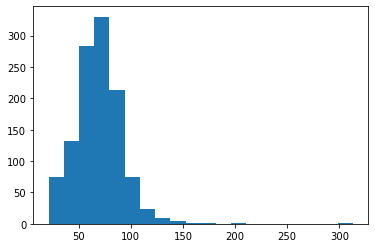

In [51]:
#looking at histograms to check how it's distributed
plt.hist(X_train['lotfrontage'], bins=20);

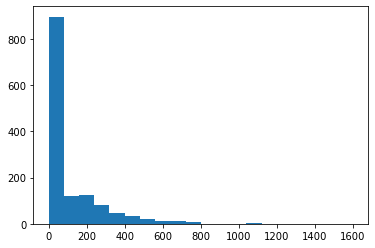

In [52]:
plt.hist(X_train['masvnrarea'], bins=20);

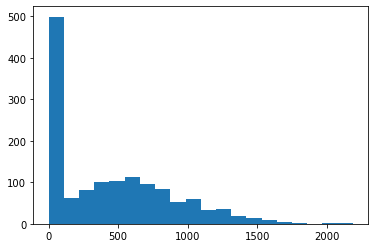

In [53]:
plt.hist(X_train['bsmtfinsf1'], bins=20);

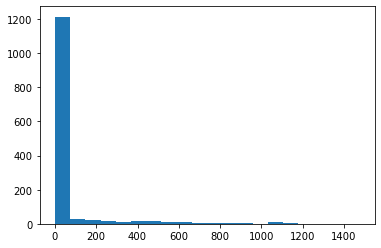

In [54]:
plt.hist(X_train['bsmtfinsf2'], bins=20);

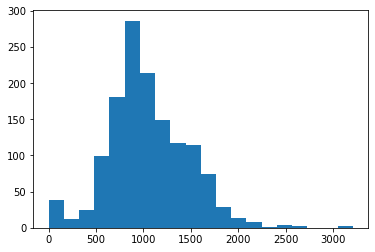

In [55]:
plt.hist(X_train['totalbsmtsf'], bins=20);
# would it be better to do the mean?

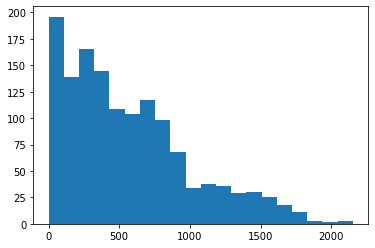

In [56]:
plt.hist(X_train['bsmtunfsf'], bins=20);

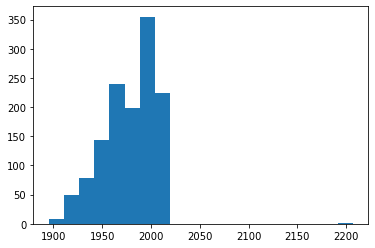

In [57]:
plt.hist(X_train['garageyrblt'], bins=20);
# replacing with medians

In [58]:
nulls = pd.DataFrame(X_train.isnull().sum())
nulls.loc[nulls[0] != 0]

#nulls in X_train for referance

,0
lotfrontage,218
masvnrtype,13
masvnrarea,13
bsmtqual,39
bsmtcond,39
bsmtexposure,40
bsmtfintype1,39
bsmtfintype2,40
garagetype,72
garageyrblt,72


#### - create imputers to address nulls for nominal, ordinal, discrete, and continuous variables

In [59]:
#impute with median
imputer1 = SimpleImputer(strategy = 'median')

# impute with str 'NA'
imputer2 = SimpleImputer(strategy = 'constant', fill_value='NA')

# imputer with most frequent
imputer3 = SimpleImputer(strategy = 'most_frequent')

# making a column transformer
imputers = make_column_transformer(
                (imputer1, ['lotfrontage','masvnrarea', 'garageyrblt']),
                (imputer2, ['bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'miscfeature']),
                (imputer3, ['masvnrtype']),
                remainder = 'passthrough',
                verbose_feature_names_out=False)  #we need false so that the feature names come out in the form we want

In [60]:
test = pd.DataFrame(imputers.fit_transform(X_train), columns=imputers.get_feature_names_out())
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1370 entries, 0 to 1369
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   lotfrontage    1370 non-null   object
 1   masvnrarea     1370 non-null   object
 2   garageyrblt    1370 non-null   object
 3   bsmtqual       1370 non-null   object
 4   bsmtcond       1370 non-null   object
 5   bsmtexposure   1370 non-null   object
 6   bsmtfintype1   1370 non-null   object
 7   bsmtfintype2   1370 non-null   object
 8   garagetype     1370 non-null   object
 9   garagefinish   1370 non-null   object
 10  garagequal     1370 non-null   object
 11  garagecond     1370 non-null   object
 12  miscfeature    1370 non-null   object
 13  masvnrtype     1370 non-null   object
 14  id             1370 non-null   object
 15  pid            1370 non-null   object
 16  mssubclass     1370 non-null   object
 17  mszoning       1370 non-null   object
 18  lotarea        1370 non-null

In [61]:
# use the pipe above to impute the nulls
# turn the output into a dataframe with the column names
X_train_imp = pd.DataFrame(imputers.fit_transform(X_train), columns=imputers.get_feature_names_out())
X_test_imp = pd.DataFrame(imputers.transform(X_test), columns=imputers.get_feature_names_out())

In [62]:
nulls = pd.DataFrame(X_train_imp.isna().sum())
nulls.loc[nulls[0] != 0]

,0


In [63]:
X_train_imp['lotfrontage'].value_counts()

# this matches what I expected. median is 68 and 221 (nulls) + 18 (actual 68)

68.0     242
60.0     120
80.0      65
70.0      61
50.0      55
        ... 
174.0      1
46.0       1
111.0      1
155.0      1
138.0      1
Name: lotfrontage, Length: 105, dtype: int64

#### - create ordinal feature encoder pipeline

In [64]:
# cols I dropped & don't need to ordinal impute - 'Pool QC', 'Fireplace Qu', 'Fence'


# 'Lot Shape'
lotshape=['IR3','IR2', 'IR1','Reg'] 
ord1 = OrdinalEncoder(categories=[lotshape],dtype=int)

# Utilities
util=['ELO','NoSeWa','NoSewr','AllPub']
ord2 = OrdinalEncoder(categories=[util],dtype=int)

# Land Slope
lslope=['Sev', 'Mod','Gtl']
ord3= OrdinalEncoder(categories=[lslope],dtype=int)


# # Overall Qual, Overall Cond - talked to ben and he said it might be unnecessary to encode these b/c they are already in valued order
# overall=['1', '2', '3','4','5','6','7','8','9','10']
# ord4= OrdinalEncoder(categories=[overall],dtype=int)


# Exter Qual, Exter Cond, Bsmt Cond, Heating QC, Kitchen Qual, Garage Qual, Garage Cond, Bsmt Qual
# don't include b/c dropped: Pool QC, Fireplace Qu
exter=['NA','Po','Fa','TA','Gd','Ex']
ord5= OrdinalEncoder(categories=[exter],dtype=int)


# Bsmt Exposure
bsmtexp=['NA','No','Mn','Av','Gd']
ord6= OrdinalEncoder(categories=[bsmtexp],dtype=int)


# BsmtFin Type 1, BsmtFinType 2
bsmtfin=['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
ord7= OrdinalEncoder(categories=[bsmtfin],dtype=int)


# Electrical
elec=['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix']
ord8= OrdinalEncoder(categories = [elec],dtype=int)


#Functional
func=['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1','Typ']
ord9= OrdinalEncoder(categories=[func],dtype=int)


#Garage Finish
gar=['NA','Unf','RFn','Fin']
ord10= OrdinalEncoder(categories=[gar],dtype=int)


#paved driveway
drive=['N','P','Y']
ord11= OrdinalEncoder(categories=[drive],dtype=int)


# Fence - I don't need this since I dropped fence col
# fence=['NA','MnWw','GdWo','MnPrv','GdPrv']
# ord12= OrdinalEncoder(categories=[[fence]])


# combine all imputers into one imputer pipe
ord_imputers = make_column_transformer(
                (ord1, ['lotshape']),
                (ord2, ['utilities']),
                (ord3, ['landslope']),
                (ord5, ['exterqual']),
                (ord5, ['extercond']),
                (ord5, ['bsmtcond']),
                (ord5, ['heatingqc']),
                (ord5, ['kitchenqual']),
                (ord5, ['garagequal']),
                (ord5, ['garagecond']),
                (ord5, ['bsmtqual']),
                (ord6, ['bsmtexposure']),
                (ord7, ['bsmtfintype1']),
                (ord7, ['bsmtfintype2']),
                (ord8, ['electrical']),
                (ord9, ['functional']),
                (ord10, ['garagefinish']),
                (ord11, ['paveddrive']),
                remainder = 'passthrough',
                verbose_feature_names_out=False)

# what I tried to do with ord5 - (ord5, ['exterqual','extercond', 'bsmtcond', 'heatingqc', 'kitchenqual', 'garagequal','garagecond', 'bsmtqual']),

In [65]:
ord_imputers.fit_transform(X_train_imp)

array([[3, 3, 2, ..., 1, 0, 0],
       [2, 3, 2, ..., 1, 0, 0],
       [3, 3, 2, ..., 1, 0, 0],
       ...,
       [3, 3, 2, ..., 1, 0, 0],
       [2, 3, 2, ..., 1, 1, 0],
       [3, 3, 2, ..., 1, 0, 0]], dtype=object)

In [66]:
# apply the ord_imputer, convert to dataframe and assign to new object
X_train_imp2 = pd.DataFrame(ord_imputers.fit_transform(X_train_imp), columns = ord_imputers.get_feature_names_out())
X_test_imp2 = pd.DataFrame(ord_imputers.fit_transform(X_test_imp), columns = ord_imputers.get_feature_names_out())

### double-checking that features that I ordinalencoded do match up to the category list

In [67]:
X_train_imp['extercond'].value_counts()
# =['NA','Po','Fa','TA','Gd','Ex']

TA    1191
Gd     137
Fa      35
Ex       5
Po       2
Name: extercond, dtype: int64

In [68]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1370 entries, 970 to 623
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1370 non-null   int64  
 1   pid            1370 non-null   int64  
 2   mssubclass     1370 non-null   int64  
 3   mszoning       1370 non-null   object 
 4   lotfrontage    1152 non-null   float64
 5   lotarea        1370 non-null   int64  
 6   street         1370 non-null   object 
 7   lotshape       1370 non-null   object 
 8   landcontour    1370 non-null   object 
 9   utilities      1370 non-null   object 
 10  lotconfig      1370 non-null   object 
 11  landslope      1370 non-null   object 
 12  neighborhood   1370 non-null   object 
 13  condition1     1370 non-null   object 
 14  condition2     1370 non-null   object 
 15  bldgtype       1370 non-null   object 
 16  housestyle     1370 non-null   object 
 17  overallqual    1370 non-null   int64  
 18  overall

In [69]:
#X_train.info()

X_train.select_dtypes(np.number).columns

Index(['id', 'pid', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremod_add', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch', 'poolarea',
       'miscval', 'mosold', 'yrsold', 'has_garage', 'has_pool', 'has_basement',
       'has_fence', 'has_alley'],
      dtype='object')

Note: When I ran my df through the imputer pipe and ordinal pipe it converted all variables to objects. I am changing select cols back into floats so they don't get dummied in the next step

In [70]:
cols_to_change = ['id', 'pid', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremod_add', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch', 'poolarea',
       'miscval', 'mosold', 'yrsold', 'has_garage', 'has_pool', 'has_basement',
       'has_fence', 'has_alley','lotshape','utilities','landslope','exterqual','extercond','bsmtcond',
       'heatingqc', 'kitchenqual', 'garagequal', 'garagecond','bsmtqual','bsmtexposure','bsmtfintype1',
        'bsmtfintype2', 'electrical','functional','garagefinish','paveddrive','overallqual','overallcond']


for col in cols_to_change:
    X_train_imp2[col] = pd.to_numeric(X_train_imp2[col])

In [71]:
cols_to_change = ['id', 'pid', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremod_add', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch', 'poolarea',
       'miscval', 'mosold', 'yrsold', 'has_garage', 'has_pool', 'has_basement',
       'has_fence', 'has_alley','lotshape','utilities','landslope','exterqual','extercond','bsmtcond',
       'heatingqc', 'kitchenqual', 'garagequal', 'garagecond','bsmtqual','bsmtexposure','bsmtfintype1',
        'bsmtfintype2', 'electrical','functional','garagefinish','paveddrive','overallqual','overallcond']


for col in cols_to_change:
    X_test_imp2[col] = pd.to_numeric(X_test_imp2[col])

In [72]:
#checking to make sure these are the only list of categoricals
X_train_imp2.select_dtypes(object).columns

Index(['garagetype', 'miscfeature', 'masvnrtype', 'mszoning', 'street',
       'landcontour', 'lotconfig', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'foundation', 'heating', 'centralair', 'saletype'],
      dtype='object')

In [73]:
X_test_imp2.select_dtypes(object).columns

Index(['garagetype', 'miscfeature', 'masvnrtype', 'mszoning', 'street',
       'landcontour', 'lotconfig', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'foundation', 'heating', 'centralair', 'saletype'],
      dtype='object')

### Dummy categorical features

In [74]:
# dummy all the cat columns - drop first
# dummy_na will separate out a column for non-value
X_train_dummied = pd.get_dummies(data=X_train_imp2, drop_first=True)
X_test_dummied = pd.get_dummies(data=X_test_imp2, drop_first=True)

In [75]:
X_train_dummied.shape

(1370, 188)

In [76]:
X_test_dummied.shape

(676, 186)

Because list of columns don't match in train and test after dummying, I am dropping unmatched columns below

In [77]:
# list of columns that are in X_train_dummied, but not in X_test_dummied
set(X_train_dummied.columns) - set(X_test_dummied.columns)

{'condition2_RRNn',
 'exterior1st_BrkComm',
 'foundation_Stone',
 'heating_OthW',
 'housestyle_2.5Fin',
 'mszoning_C (all)',
 'neighborhood_Landmrk',
 'roofmatl_Membran',
 'saletype_ConLw',
 'saletype_Oth'}

In [78]:
#dropping columns in train that isn't in 

X_train_dummied.drop(columns=['condition2_RRNn',
 'exterior1st_BrkComm',
 'foundation_Stone',
 'heating_OthW',
 'housestyle_2.5Fin',
 'mszoning_C (all)',
 'neighborhood_Landmrk',
 'roofmatl_Membran',
 'saletype_ConLw',
 'saletype_Oth'], inplace=True)

In [79]:
set(X_test_dummied.columns) - set(X_train_dummied.columns)

{'condition2_RRAe',
 'condition2_RRAn',
 'exterior1st_AsphShn',
 'exterior1st_ImStucc',
 'exterior2nd_CBlock',
 'foundation_Wood',
 'miscfeature_TenC',
 'mszoning_I (all)'}

In [80]:
#dropping columns in X_test_dummied

X_test_dummied.drop(columns = 
                ['condition2_RRAe',
                 'condition2_RRAn',
                 'exterior1st_AsphShn',
                 'exterior1st_ImStucc',
                 'exterior2nd_CBlock',
                 'foundation_Wood',
                 'miscfeature_TenC',
                 'mszoning_I (all)'],
                inplace = True)

In [81]:
print('X_train_dummied:', X_train_dummied.shape)
print('y_train:', y_train.shape)
print('X_test_dummied:', X_test_dummied.shape)
print('y_test:', y_test.shape)

X_train_dummied: (1370, 178)
y_train: (1370, 2)
X_test_dummied: (676, 178)
y_test: (676, 2)


Before scaling, dropping 'id' and 'pid'

In [82]:
#X_train
X_train_toscale = X_train_dummied.drop(columns = ['id', 'pid'])
X_train_id = X_train_dummied[['id', 'pid']]

#X_test
X_test_toscale = X_test_dummied.drop(columns = ['id', 'pid'])
X_test_id = X_test_dummied[['id', 'pid']]

In [83]:
X_train_toscale.head(2)

,lotshape,utilities,landslope,exterqual,extercond,bsmtcond,heatingqc,kitchenqual,garagequal,garagecond,...,heating_GasW,heating_Grav,heating_Wall,centralair_Y,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_New,saletype_WD
0,3,3,2,3,4,3,3,3,3,3,...,0,0,0,1,0,0,0,0,0,1
1,2,3,2,4,3,3,5,4,3,3,...,0,0,0,1,0,0,0,0,0,1


In [84]:
X_test_toscale.head(2)

,lotshape,utilities,landslope,exterqual,extercond,bsmtcond,heatingqc,kitchenqual,garagequal,garagecond,...,heating_GasW,heating_Grav,heating_Wall,centralair_Y,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_New,saletype_WD
0,3,3,2,3,3,3,4,3,3,3,...,0,0,0,1,0,0,0,0,0,1
1,3,3,2,3,3,3,3,3,3,3,...,0,0,0,1,0,0,0,0,0,1


### Use standard scalar to fit and transform data

In [85]:
#instantiate the StandardScaler
sc = StandardScaler()

In [86]:
#transform and fit the function to training/transform on testing data
Z_train = pd.DataFrame(sc.fit_transform(X_train_toscale), columns = X_train_toscale.columns)
Z_test = pd.DataFrame(sc.transform(X_test_toscale), columns = X_test_toscale.columns)

In [87]:
# join the ids and scaled df back together
Z_train = pd.concat([X_train_id, Z_train], axis=1)
Z_test = pd.concat([X_test_id, Z_test], axis=1)

In [88]:
X_train_id

,id,pid
0,2172,908127060
1,949,914465055
2,2871,909428110
3,1173,533217050
4,454,528174070
...,...,...
1365,2369,527451200
1366,656,535375050
1367,240,905452160
1368,1541,909428170


In [89]:
Z_train

,id,pid,lotshape,utilities,landslope,exterqual,extercond,bsmtcond,heatingqc,kitchenqual,...,heating_GasW,heating_Grav,heating_Wall,centralair_Y,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_New,saletype_WD
0,2172,908127060,0.707844,0.027027,0.222679,-0.691914,2.463942,0.131568,-1.206332,-0.776955,...,-0.097877,-0.046846,-0.054113,0.27909,-0.066324,-0.046846,-0.085749,-0.060523,-0.304145,0.407379
1,949,914465055,-1.036305,0.027027,0.222679,1.006871,-0.210860,0.131568,0.865988,0.726475,...,-0.097877,-0.046846,-0.054113,0.27909,-0.066324,-0.046846,-0.085749,-0.060523,-0.304145,0.407379
2,2871,909428110,0.707844,0.027027,0.222679,-0.691914,-0.210860,0.131568,-1.206332,-0.776955,...,-0.097877,-0.046846,-0.054113,0.27909,-0.066324,-0.046846,-0.085749,-0.060523,-0.304145,0.407379
3,1173,533217050,0.707844,0.027027,0.222679,1.006871,-0.210860,0.131568,0.865988,0.726475,...,-0.097877,-0.046846,-0.054113,0.27909,-0.066324,-0.046846,-0.085749,-0.060523,-0.304145,0.407379
4,454,528174070,-1.036305,0.027027,0.222679,1.006871,-0.210860,0.131568,0.865988,0.726475,...,-0.097877,-0.046846,-0.054113,0.27909,-0.066324,-0.046846,-0.085749,-0.060523,-0.304145,0.407379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,2369,527451200,0.707844,0.027027,0.222679,-0.691914,-0.210860,0.131568,-1.206332,-0.776955,...,-0.097877,-0.046846,-0.054113,0.27909,-0.066324,-0.046846,-0.085749,-0.060523,-0.304145,0.407379
1366,656,535375050,0.707844,0.027027,0.222679,-0.691914,-0.210860,0.131568,0.865988,-0.776955,...,-0.097877,-0.046846,-0.054113,0.27909,-0.066324,-0.046846,-0.085749,-0.060523,-0.304145,0.407379
1367,240,905452160,0.707844,0.027027,0.222679,-0.691914,-0.210860,0.131568,-1.206332,-0.776955,...,-0.097877,-0.046846,-0.054113,0.27909,-0.066324,-0.046846,-0.085749,-0.060523,-0.304145,0.407379
1368,1541,909428170,-1.036305,0.027027,0.222679,-0.691914,-0.210860,0.131568,0.865988,-0.776955,...,-0.097877,-0.046846,-0.054113,0.27909,-0.066324,-0.046846,-0.085749,-0.060523,-0.304145,0.407379


In [90]:
X_test_id

,id,pid
0,1844,533213140
1,793,905452050
2,912,909250220
3,1140,531382090
4,2878,910226060
...,...,...
671,1929,535181140
672,2930,924151050
673,705,902135020
674,2471,531363080


In [91]:
Z_test

,id,pid,lotshape,utilities,landslope,exterqual,extercond,bsmtcond,heatingqc,kitchenqual,...,heating_GasW,heating_Grav,heating_Wall,centralair_Y,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_New,saletype_WD
0,1844,533213140,0.707844,0.027027,0.222679,-0.691914,-0.21086,0.131568,-0.170172,-0.776955,...,-0.097877,-0.046846,-0.054113,0.279090,-0.066324,-0.046846,-0.085749,-0.060523,-0.304145,0.407379
1,793,905452050,0.707844,0.027027,0.222679,-0.691914,-0.21086,0.131568,-1.206332,-0.776955,...,-0.097877,-0.046846,-0.054113,0.279090,-0.066324,-0.046846,-0.085749,-0.060523,-0.304145,0.407379
2,912,909250220,0.707844,0.027027,0.222679,-0.691914,-0.21086,0.131568,-1.206332,0.726475,...,-0.097877,-0.046846,-0.054113,0.279090,-0.066324,-0.046846,-0.085749,-0.060523,-0.304145,0.407379
3,1140,531382090,-1.036305,0.027027,0.222679,1.006871,-0.21086,0.131568,0.865988,0.726475,...,-0.097877,-0.046846,-0.054113,0.279090,-0.066324,-0.046846,-0.085749,-0.060523,-0.304145,0.407379
4,2878,910226060,0.707844,0.027027,0.222679,-0.691914,-0.21086,0.131568,-0.170172,0.726475,...,-0.097877,-0.046846,-0.054113,0.279090,-0.066324,-0.046846,-0.085749,-0.060523,-0.304145,0.407379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,1929,535181140,-1.036305,0.027027,0.222679,-0.691914,-0.21086,0.131568,-1.206332,-0.776955,...,-0.097877,-0.046846,-0.054113,0.279090,-0.066324,-0.046846,-0.085749,-0.060523,-0.304145,-2.454718
672,2930,924151050,0.707844,0.027027,-3.688479,-0.691914,-0.21086,0.131568,0.865988,-0.776955,...,-0.097877,-0.046846,-0.054113,0.279090,-0.066324,-0.046846,-0.085749,-0.060523,-0.304145,0.407379
673,705,902135020,0.707844,0.027027,-3.688479,-2.390698,-0.21086,0.131568,-1.206332,-0.776955,...,-0.097877,-0.046846,-0.054113,-3.583069,-0.066324,-0.046846,-0.085749,-0.060523,-0.304145,0.407379
674,2471,531363080,-1.036305,0.027027,0.222679,-0.691914,-0.21086,0.131568,0.865988,0.726475,...,-0.097877,-0.046846,-0.054113,0.279090,-0.066324,-0.046846,-0.085749,-0.060523,-0.304145,0.407379


Exporting final cleaned datasets - pre-feature engineering

In [92]:
#export dataset to csv
Z_train.to_csv('cleaned_datasets/housing_Z_train_processed_data.csv', index = False)
Z_test.to_csv('cleaned_datasets/housing_Z_test_processed_data.csv', index = False)
y_train.to_csv('cleaned_datasets/housing_y-train.csv', index=False)
y_test.to_csv('cleaned_datasets/housing_y-test_data.csv', index=False)

### Merging sale price into the cleaned/scaled dataframe to run a proper correlation on training dataset

In [93]:
saleprice_df = housing[['id','saleprice']] #extracted these 2 cols from the original dataset
saleprice_df['id'] = saleprice_df['id'].astype('float')

In [94]:
# created a df that I'm going to use to check for correlations & running through VIF model
Z_train_corr = Z_train.merge(saleprice_df, left_on='id', right_on='id')
Z_train_corr.shape

(1370, 179)

In [95]:
#remove ID and PID before running correlations & VIF
Z_train_corr.drop(columns= ['pid', 'id'], inplace=True)

### Correlation to SalePrice

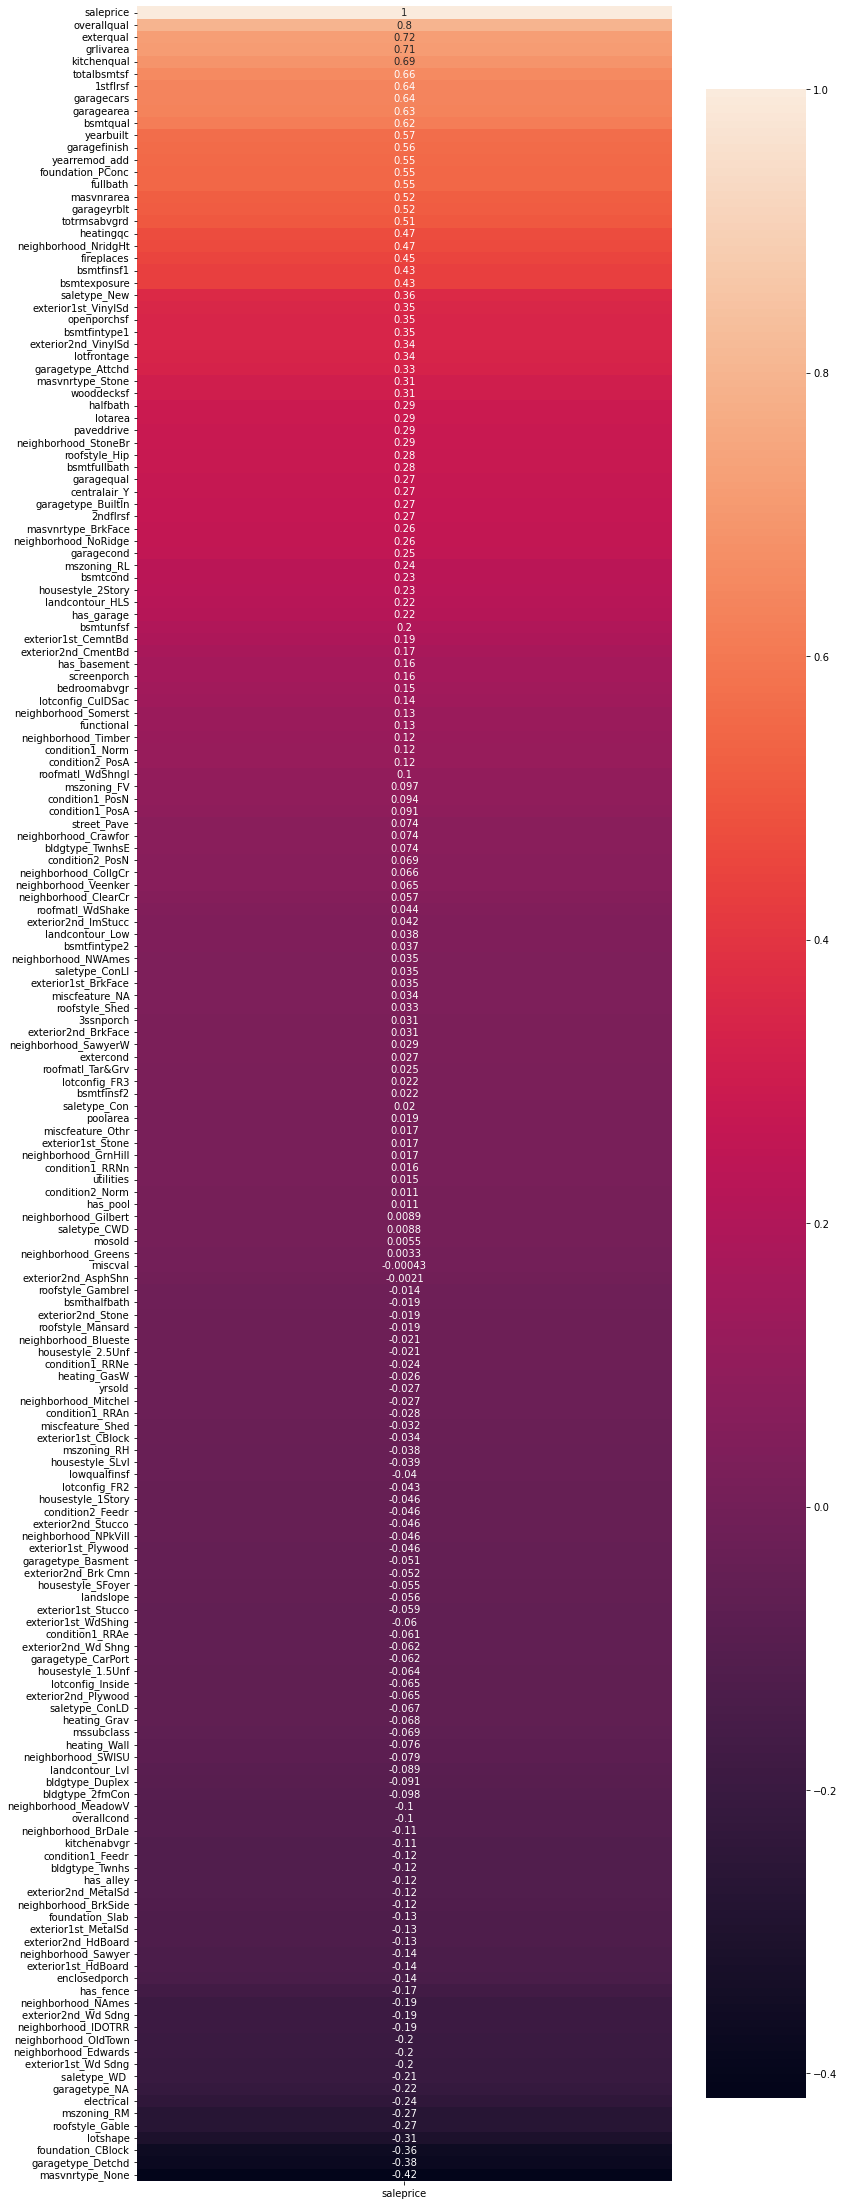

In [96]:
# run a heatmap with correlations to the target to get a general feel for correlation between variables and target
plt.figure(figsize = (12,40))
sns.heatmap(Z_train_corr.corr()[['saleprice']].sort_values(['saleprice'], ascending=False), annot=True);

In [97]:
# create a df of the correlations
correlations = Z_train_corr.corr()[['saleprice']].sort_values(['saleprice'], ascending=False)

# rename correlations column
correlations = correlations.rename(columns = {'saleprice': 'corr'})

# only return if correlation is greater than 0.1 or less than -.1
correlations = correlations[(correlations['corr'] >= 0.10) | (correlations['corr'] <= -0.10)] 
tokeep = correlations.index  #list of features to keep
len(tokeep)

93

In [98]:
tokeep

Index(['saleprice', 'overallqual', 'exterqual', 'grlivarea', 'kitchenqual',
       'totalbsmtsf', '1stflrsf', 'garagecars', 'garagearea', 'bsmtqual',
       'yearbuilt', 'garagefinish', 'yearremod_add', 'foundation_PConc',
       'fullbath', 'masvnrarea', 'garageyrblt', 'totrmsabvgrd', 'heatingqc',
       'neighborhood_NridgHt', 'fireplaces', 'bsmtfinsf1', 'bsmtexposure',
       'saletype_New', 'exterior1st_VinylSd', 'openporchsf', 'bsmtfintype1',
       'exterior2nd_VinylSd', 'lotfrontage', 'garagetype_Attchd',
       'masvnrtype_Stone', 'wooddecksf', 'halfbath', 'lotarea', 'paveddrive',
       'neighborhood_StoneBr', 'roofstyle_Hip', 'bsmtfullbath', 'garagequal',
       'centralair_Y', 'garagetype_BuiltIn', '2ndflrsf', 'masvnrtype_BrkFace',
       'neighborhood_NoRidge', 'garagecond', 'mszoning_RL', 'bsmtcond',
       'housestyle_2Story', 'landcontour_HLS', 'has_garage', 'bsmtunfsf',
       'exterior1st_CemntBd', 'exterior2nd_CmentBd', 'has_basement',
       'screenporch', 'bedroomab

In [99]:
# make a copy of df and assign it to new df - this is the df i'm running through VIF
Z_train_VIF = Z_train_corr.copy()

In [100]:
Z_train_VIF.shape

(1370, 177)

In [101]:
Z_train_VIF = Z_train_VIF[tokeep]
Z_train_VIF.shape

(1370, 93)

In [102]:
pd.set_option('display.max_rows', 200)

### Running df through VIF to remove any features that have show strong multicollinearity

In [103]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [104]:
def vif_dropper(df):  #input a dataframe
    df_new = df
    while True:  #creating a while loop
        df_vif = pd.DataFrame()        # create blank dataframe and assigning it to vif_data
        df_vif["feature"] = df_new.columns   # create a new column called feature that extracts col names
        df_vif["VIF"] = [variance_inflation_factor(df_new.values, i) for i in range(len(df_new.columns))] #calculates VIF for each feature and adds it to blank df

        v = df_vif[df_vif['VIF'] != float('inf')] #filter df for VIF values that are above 5 and not inf & saving to new df called v
        m = max([i for i in v['VIF']])   # for each of the VIF vals in v df, return the max
        #print(m)
        
        if m < 5:
            break
            
        else:
            feature = df_vif.iloc[df_vif[df_vif['VIF'] == m].index]['feature'].values[0]
            df_new.drop(columns = feature, inplace=True)
            # print(feature)
            
    return df_new

In [105]:
vif_dropper(Z_train_VIF)

,saleprice,overallqual,exterqual,kitchenqual,garagearea,garagefinish,yearremod_add,fullbath,masvnrarea,garageyrblt,...,neighborhood_OldTown,neighborhood_Edwards,exterior1st_Wd Sdng,saletype_WD,garagetype_NA,electrical,mszoning_RM,lotshape,foundation_CBlock,garagetype_Detchd
0,122000,-0.773547,-0.691914,-0.776955,0.452552,-0.793582,-1.637387,-1.027428,-0.578394,-0.127244,...,-0.304145,3.525815,-0.40616,0.407379,-0.235521,-0.273935,-0.427872,0.707844,1.184698,1.634907
1,240000,0.623631,1.006871,0.726475,0.332526,1.452715,0.982641,0.774846,0.071602,1.006512,...,-0.304145,-0.283622,-0.40616,0.407379,-0.235521,-0.273935,-0.427872,-1.036305,-0.844097,-0.611655
2,157000,-0.773547,-0.691914,-0.776955,-0.475344,-0.793582,-1.494476,-1.027428,-0.241359,-0.987336,...,-0.304145,-0.283622,-0.40616,0.407379,-0.235521,-0.273935,-0.427872,0.707844,1.184698,-0.611655
3,160000,0.623631,1.006871,0.726475,-0.073717,-0.793582,0.744456,0.774846,0.697525,0.811037,...,-0.304145,-0.283622,-0.40616,0.407379,-0.235521,-0.273935,-0.427872,0.707844,-0.844097,1.634907
4,184500,-0.074958,1.006871,0.726475,0.674139,0.329566,0.982641,0.774846,0.234101,1.045607,...,-0.304145,-0.283622,-0.40616,0.407379,-0.235521,-0.273935,-0.427872,-1.036305,-0.844097,-0.611655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,91500,-0.074958,-0.691914,-0.776955,-2.206494,-1.916731,-0.637013,-1.027428,0.841968,0.029136,...,-0.304145,-0.283622,-0.40616,0.407379,4.245913,-0.273935,2.337149,0.707844,1.184698,-0.611655
1366,135000,-0.773547,-0.691914,-0.776955,-1.375542,-0.793582,0.125177,0.774846,-0.578394,-2.433853,...,3.287909,-0.283622,-0.40616,0.407379,-0.235521,-0.273935,-0.427872,0.707844,1.184698,1.634907
1367,128000,-0.773547,-0.691914,-0.776955,-0.516892,1.452715,0.649183,-1.027428,-0.578394,-0.948241,...,-0.304145,3.525815,-0.40616,0.407379,-0.235521,-0.273935,-0.427872,0.707844,1.184698,-0.611655
1368,236500,-0.773547,-0.691914,-0.776955,0.027843,-0.793582,-1.351566,0.774846,-0.578394,-0.870051,...,-0.304145,-0.283622,-0.40616,0.407379,-0.235521,2.163016,-0.427872,-1.036305,-0.844097,-0.611655


#### After selecting features by observing correlation and running it through VIF, I am left with 74 features in my model

In [106]:
#columns I want to keep
Z_train_VIF.columns

Index(['saleprice', 'overallqual', 'exterqual', 'kitchenqual', 'garagearea',
       'garagefinish', 'yearremod_add', 'fullbath', 'masvnrarea',
       'garageyrblt', 'totrmsabvgrd', 'heatingqc', 'neighborhood_NridgHt',
       'fireplaces', 'bsmtfinsf1', 'bsmtexposure', 'saletype_New',
       'openporchsf', 'bsmtfintype1', 'exterior2nd_VinylSd', 'lotfrontage',
       'masvnrtype_Stone', 'wooddecksf', 'halfbath', 'lotarea', 'paveddrive',
       'neighborhood_StoneBr', 'roofstyle_Hip', 'bsmtfullbath', 'centralair_Y',
       'garagetype_BuiltIn', 'masvnrtype_BrkFace', 'neighborhood_NoRidge',
       'bsmtcond', 'housestyle_2Story', 'landcontour_HLS', 'has_garage',
       'bsmtunfsf', 'exterior2nd_CmentBd', 'screenporch', 'bedroomabvgr',
       'lotconfig_CulDSac', 'neighborhood_Somerst', 'functional',
       'neighborhood_Timber', 'condition1_Norm', 'condition2_PosA',
       'neighborhood_MeadowV', 'overallcond', 'neighborhood_BrDale',
       'kitchenabvgr', 'condition1_Feedr', 'bldgtype_Twn

In [107]:
# cols to keep
lst = ['pid','id','overallqual', 'exterqual', 'kitchenqual', 'garagearea',
       'garagefinish', 'yearremod_add', 'fullbath', 'masvnrarea',
       'garageyrblt', 'totrmsabvgrd', 'heatingqc', 'neighborhood_NridgHt',
       'fireplaces', 'bsmtfinsf1', 'bsmtexposure', 'saletype_New',
       'openporchsf', 'bsmtfintype1', 'exterior2nd_VinylSd', 'lotfrontage',
       'masvnrtype_Stone', 'wooddecksf', 'halfbath', 'lotarea', 'paveddrive',
       'neighborhood_StoneBr', 'roofstyle_Hip', 'bsmtfullbath', 'centralair_Y',
       'garagetype_BuiltIn', 'masvnrtype_BrkFace', 'neighborhood_NoRidge',
       'bsmtcond', 'housestyle_2Story', 'landcontour_HLS', 'has_garage',
       'bsmtunfsf', 'exterior2nd_CmentBd', 'screenporch', 'bedroomabvgr',
       'lotconfig_CulDSac', 'neighborhood_Somerst', 'functional',
       'neighborhood_Timber', 'condition1_Norm', 'condition2_PosA',
       'neighborhood_MeadowV', 'overallcond', 'neighborhood_BrDale',
       'kitchenabvgr', 'condition1_Feedr', 'bldgtype_Twnhs', 'has_alley',
       'exterior2nd_MetalSd', 'neighborhood_BrkSide', 'foundation_Slab',
       'exterior2nd_HdBoard', 'neighborhood_Sawyer', 'enclosedporch',
       'has_fence', 'neighborhood_NAmes', 'exterior2nd_Wd Sdng',
       'neighborhood_IDOTRR', 'neighborhood_OldTown', 'neighborhood_Edwards',
       'exterior1st_Wd Sdng', 'saletype_WD ', 'garagetype_NA', 'electrical',
       'mszoning_RM', 'lotshape', 'foundation_CBlock', 'garagetype_Detchd']

In [108]:
# reassigning the df post VIF function to a new df called df_model
df_model_train = Z_train[lst]

# dropping same features from Z_test
df_model_test = Z_test[lst]

In [109]:
df_model_train.shape

(1370, 75)

In [110]:
df_model_test.shape

(676, 75)

In [111]:
print('df_model_train:', df_model_train.shape)
print('df_model_test:', df_model_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

df_model_train: (1370, 75)
df_model_test: (676, 75)
y_train: (1370, 2)
y_test: (676, 2)


In [112]:
df_model_train

,pid,id,overallqual,exterqual,kitchenqual,garagearea,garagefinish,yearremod_add,fullbath,masvnrarea,...,neighborhood_OldTown,neighborhood_Edwards,exterior1st_Wd Sdng,saletype_WD,garagetype_NA,electrical,mszoning_RM,lotshape,foundation_CBlock,garagetype_Detchd
0,908127060,2172,-0.773547,-0.691914,-0.776955,0.452552,-0.793582,-1.637387,-1.027428,-0.578394,...,-0.304145,3.525815,-0.40616,0.407379,-0.235521,-0.273935,-0.427872,0.707844,1.184698,1.634907
1,914465055,949,0.623631,1.006871,0.726475,0.332526,1.452715,0.982641,0.774846,0.071602,...,-0.304145,-0.283622,-0.40616,0.407379,-0.235521,-0.273935,-0.427872,-1.036305,-0.844097,-0.611655
2,909428110,2871,-0.773547,-0.691914,-0.776955,-0.475344,-0.793582,-1.494476,-1.027428,-0.241359,...,-0.304145,-0.283622,-0.40616,0.407379,-0.235521,-0.273935,-0.427872,0.707844,1.184698,-0.611655
3,533217050,1173,0.623631,1.006871,0.726475,-0.073717,-0.793582,0.744456,0.774846,0.697525,...,-0.304145,-0.283622,-0.40616,0.407379,-0.235521,-0.273935,-0.427872,0.707844,-0.844097,1.634907
4,528174070,454,-0.074958,1.006871,0.726475,0.674139,0.329566,0.982641,0.774846,0.234101,...,-0.304145,-0.283622,-0.40616,0.407379,-0.235521,-0.273935,-0.427872,-1.036305,-0.844097,-0.611655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,527451200,2369,-0.074958,-0.691914,-0.776955,-2.206494,-1.916731,-0.637013,-1.027428,0.841968,...,-0.304145,-0.283622,-0.40616,0.407379,4.245913,-0.273935,2.337149,0.707844,1.184698,-0.611655
1366,535375050,656,-0.773547,-0.691914,-0.776955,-1.375542,-0.793582,0.125177,0.774846,-0.578394,...,3.287909,-0.283622,-0.40616,0.407379,-0.235521,-0.273935,-0.427872,0.707844,1.184698,1.634907
1367,905452160,240,-0.773547,-0.691914,-0.776955,-0.516892,1.452715,0.649183,-1.027428,-0.578394,...,-0.304145,3.525815,-0.40616,0.407379,-0.235521,-0.273935,-0.427872,0.707844,1.184698,-0.611655
1368,909428170,1541,-0.773547,-0.691914,-0.776955,0.027843,-0.793582,-1.351566,0.774846,-0.578394,...,-0.304145,-0.283622,-0.40616,0.407379,-0.235521,2.163016,-0.427872,-1.036305,-0.844097,-0.611655


In [113]:
y_train

,id,saleprice
970,2172,122000
1762,949,240000
602,2871,157000
585,1173,160000
2009,454,184500
...,...,...
406,2369,91500
1414,656,135000
143,240,128000
1265,1541,236500


In [114]:
df_model_test

,pid,id,overallqual,exterqual,kitchenqual,garagearea,garagefinish,yearremod_add,fullbath,masvnrarea,...,neighborhood_OldTown,neighborhood_Edwards,exterior1st_Wd Sdng,saletype_WD,garagetype_NA,electrical,mszoning_RM,lotshape,foundation_CBlock,garagetype_Detchd
0,533213140,1844,-0.074958,-0.691914,-0.776955,-0.175278,-0.793582,0.696820,0.774846,6.216474,...,-0.304145,-0.283622,-0.40616,0.407379,-0.235521,-0.273935,-0.427872,0.707844,-0.844097,1.634907
1,905452050,793,-1.472135,-0.691914,-0.776955,-1.126256,-0.793582,-1.637387,-1.027428,-0.578394,...,-0.304145,3.525815,-0.40616,0.407379,-0.235521,-0.273935,-0.427872,0.707844,1.184698,-0.611655
2,909250220,912,-1.472135,-0.691914,0.726475,0.452552,-0.793582,-1.637387,0.774846,-0.578394,...,-0.304145,-0.283622,-0.40616,0.407379,-0.235521,-0.273935,-0.427872,0.707844,-0.844097,1.634907
3,531382090,1140,-0.074958,1.006871,0.726475,0.217116,0.329566,0.506272,0.774846,-0.349691,...,-0.304145,-0.283622,-0.40616,0.407379,-0.235521,-0.273935,-0.427872,-1.036305,-0.844097,-0.611655
4,910226060,2878,-0.074958,-0.691914,0.726475,-0.433797,-0.793582,-1.303929,0.774846,1.389650,...,-0.304145,-0.283622,-0.40616,0.407379,-0.235521,-0.273935,2.337149,0.707844,1.184698,1.634907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,535181140,1929,-0.773547,-0.691914,-0.776955,-0.775410,0.329566,-0.446465,-1.027428,-0.578394,...,-0.304145,-0.283622,-0.40616,-2.454718,-0.235521,-0.273935,-0.427872,-1.036305,1.184698,-0.611655
672,924151050,2930,0.623631,-0.691914,-0.776955,0.794166,1.452715,0.458635,0.774846,-0.012656,...,-0.304145,-0.283622,-0.40616,0.407379,-0.235521,-0.273935,-0.427872,0.707844,-0.844097,-0.611655
673,902135020,705,-1.472135,-2.390698,-0.776955,0.452552,-0.793582,-1.494476,-1.027428,-0.578394,...,3.287909,-0.283622,-0.40616,0.407379,-0.235521,-0.273935,2.337149,0.707844,1.184698,1.634907
674,531363080,2471,-0.074958,-0.691914,0.726475,-2.206494,-1.916731,0.982641,-1.027428,-0.578394,...,-0.304145,-0.283622,-0.40616,0.407379,4.245913,-0.273935,-0.427872,-1.036305,-0.844097,-0.611655


In [115]:
y_test

,id,saleprice
1149,1844,176000
1716,793,113000
51,912,135000
2039,1140,182000
584,2878,139000
...,...,...
1044,1929,130000
522,2930,188000
503,705,93000
740,2471,139500


In [116]:
#export data to csv
df_model_train.to_csv('cleaned_datasets/housing_df_model_train.csv', index = False)
df_model_test.to_csv('cleaned_datasets/housing_df_model_test.csv', index = False)